In [37]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers

### This dataset contains the information of a composite in degradation for 12 months and its changes were recorded. And it was started in the European research and innovation project IMPROVE.¶

In [38]:
# import glob
# files = glob.glob('../datasets/blade_degradation/oneyeardata/*.csv')
# combined_df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
# combined_df.to_csv('../datasets/blade_degradation/oneyearcombined.csv', index=False)

In [39]:
df = pd.read_csv('../datasets/blade_degradation/oneyearcombined.csv')

In [40]:
df.head()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
0,0.008,-0.391177,0.043663,99165279,5170.440430,89085477,4250.770020,0.667699,1379.999756
1,0.012,-0.392663,0.010400,99165299,5139.541504,89085493,4220.568848,0.635805,1379.999756
2,0.016,-0.183822,-0.037114,99165320,5129.241699,89085510,4175.267578,0.645036,1379.999756
3,0.020,-0.248531,-0.007307,99165341,5191.040039,89085526,4124.933105,0.694578,1379.999756
4,0.024,-0.266069,-0.006601,99165361,5184.173340,89085542,4087.181885,0.693916,1379.999756


In [41]:
# order by timestamp
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)
df.head()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
0,0.004,-0.136758,-0.021130,200469919,8250.044922,46473333,4721.399902,0.624389,2699.999512
1,0.004,0.109051,-0.037593,84026334,8631.133789,263069497,4995.724121,0.464140,2699.999512
2,0.004,0.315349,0.006248,505642765,-24.032593,3491663,88.085823,0.534294,1379.999756
3,0.004,-0.060628,0.063506,940860103,8874.892578,414775708,5176.929199,0.538093,2699.999512
4,0.008,-0.094693,0.028631,84026368,8500.670898,263069517,4877.437500,0.428551,2699.999512


<Axes: >

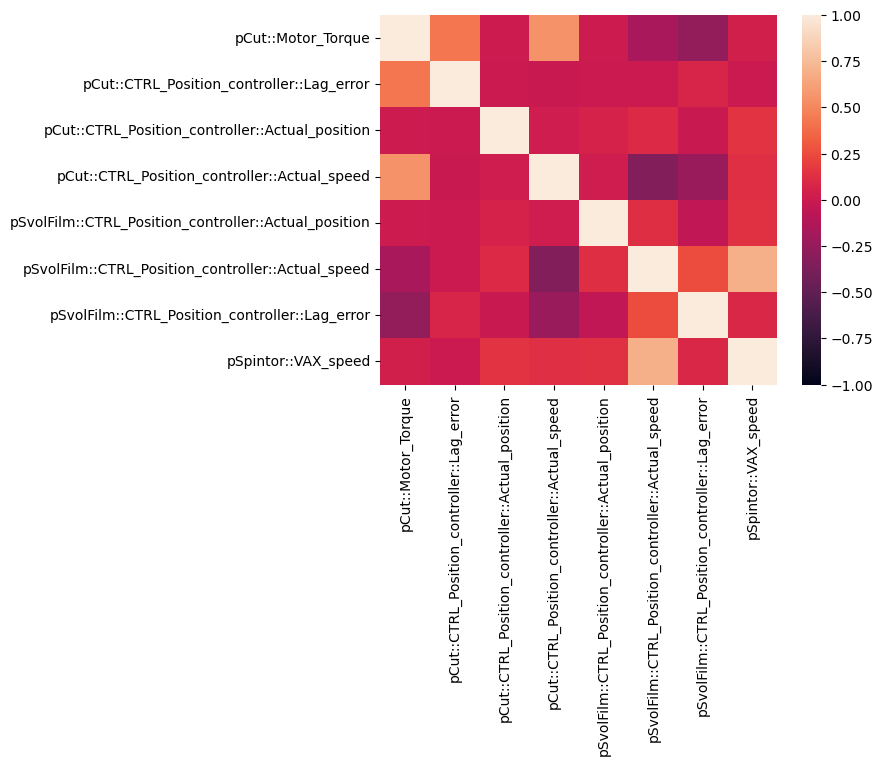

In [42]:
#Dropping nonsense columns for this proposal                                 (axis=1) = columns
df = df.drop(['timestamp'], axis=1)
#Flipping column values
df['pCut::Motor_Torque'] = df['pCut::Motor_Torque'] *-1
#Heatmap
sns.heatmap(df.corr(), vmin= -1, vmax = 1)

In [44]:
# print mean and standard deviation statistics for each column
df.describe().loc[['mean', 'std'], :]

,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
mean,0.120634,-0.000055,3.371415e+08,1945.794809,1.488169e+08,5367.031778,0.984759,1927.328330
std,0.607871,0.121212,5.466868e+08,4873.922235,2.711355e+08,3382.193664,0.343720,655.904709


In [3]:
def handle_non_numeric(df):
    # Values in each column for each column
    columns = df.columns.values
    
    for column in columns:
        
        # Dictionary with each numerical value for each text
        text_digit_vals = {}
        
        # Receives text to convert to a number
        def convert_to_int (val):
            
            # Returns respective numerical value for class
            return text_digit_vals[val]
        
        # If values in columns are not float or int
        if df[column].dtype !=np.int64 and df[column].dtype != np.float64:
            
            # Gets values form current column
            column_contents = df[column].values.tolist()
            
            # Gets unique values from current column
            unique_elements = set(column_contents)
            
            # Classification starts at 0
            x=0
            
            for unique in unique_elements:
                
                # Adds the class value for the text in dictionary, if it's not there
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
            
            # Maps the numerical values to the text values in columns 
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

# Using SVM(OneClassSVM) to detect the anomaly in the dataset.

In [ ]:
# df = handle_non_numeric(df)
# X = df
# scaler = preprocessing.MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(X), 
#                               columns=X.columns, 
#                               index=X.index)
# X = preprocessing.scale(X)
# X = pd.DataFrame(X, columns=df.columns)
# X_train = X[:10]
# ocsvm = OneClassSVM(nu=0.01, verbose=1)
# ocsvm.fit(X)

[LibSVM]...

## KMeans

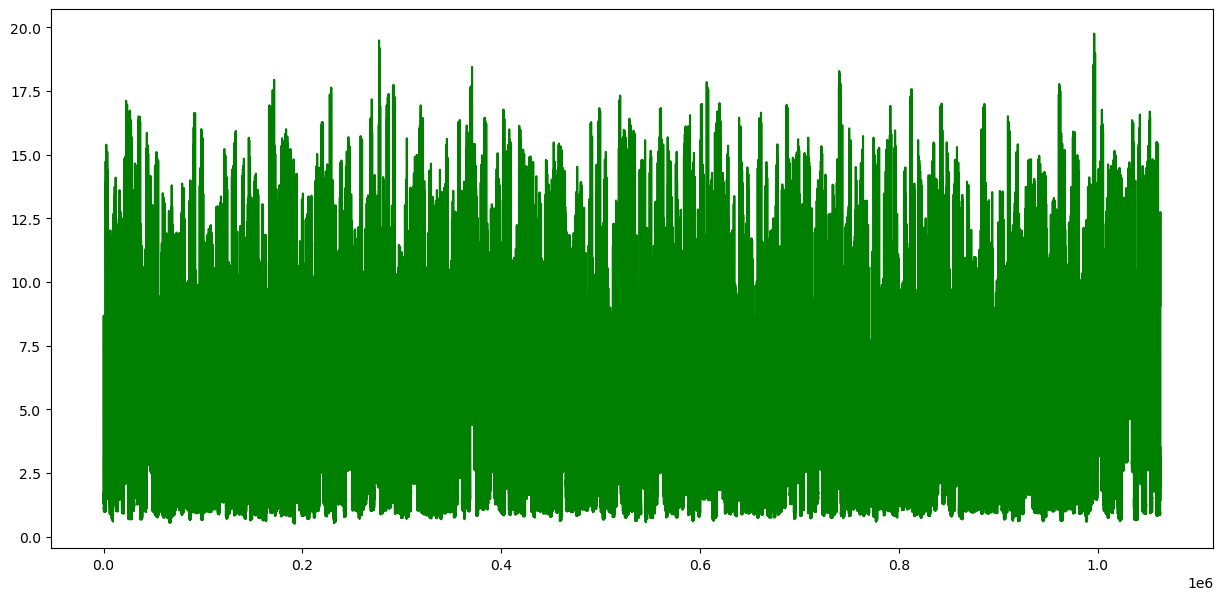

In [6]:
#------ Preparing features for training and future prediction -----
main_df = pd.read_csv('../datasets/blade_degradation/oneyearcombined.csv')
main_df = main_df.drop(['timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)
#-------------------------------------------------------------------


#Percentage of the data that will be considered healthy condition
train_percentage = 0.15
#Integer value for the slice that will be considered healthy condition
train_size = int(len(main_df.index)*train_percentage)
#Grabbing slice for training data
X_train = X[:train_size]


#Defining KMeans with 1 cluster
kmeans = KMeans(n_clusters=1)
#Fitting the algorithm
kmeans.fit(X_train)

#Creating a copy of the main dataset
k_anomaly = main_df.copy()

#Dataframe now will receive the distance of each data sample from the cluster
k_anomaly = pd.DataFrame(kmeans.transform(X))

#Saving cluster distane into csv file
k_anomaly.to_csv('KM_Distance.csv')

#Plot
plt.subplots(figsize=(15,7))

plt.plot(k_anomaly.index, k_anomaly[0], 'g', markersize=1)

## Autoencoder

In [8]:
#------------------------- Preparing data for training --------------------------- 
main_df = pd.read_csv('../datasets/blade_degradation/oneyearcombined.csv')
main_df = main_df.drop(['timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]
#----------------------------------------------------------------------------------



#Seed for random batch validation and training
seed(10)


#Elu activatoin function
act_func = 'elu'

# Input layer
model=Sequential()

# First hidden layer, connected to input vector X. 
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )
# Second hidden layer
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))
# Thrid hidden layer
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))

# Input layer
model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

# Loss function and Optimizer choice
model.compile(loss='mse',optimizer='adam')

# Train model for 50 epochs, batch size of 200 
NUM_EPOCHS=50
BATCH_SIZE=200

#Grabbing validation and training loss over epochs
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)


/home/shankerabhigyan/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731855923.949072  255296 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4622 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1731855925.788001  256148 service.cc:148] XLA service 0x7734e4003ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731855925.788041  256148 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-17 20:35:25.833717: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731855925.937578  256148 cuda_dnn.cc:529] Loaded cuDNN version 90300


101/718 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5591

I0000 00:00:1731855926.718710  256148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1862 - val_loss: 0.0050
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6791e-04 - val_loss: 8.8418e-04
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5978e-04 - val_loss: 5.5185e-04
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9453e-04 - val_loss: 4.1533e-04
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7994e-04 - val_loss: 2.8392e-04
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0382e-04 - val_loss: 2.8204e-04
Epoch 9/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6498e-04 - val_loss: 1.8608e-04
Epoch 10/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4603e-04 - val_loss: 1.6610e-04
Epoch 11/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2318e-04 - val_loss: 1.7651e-04

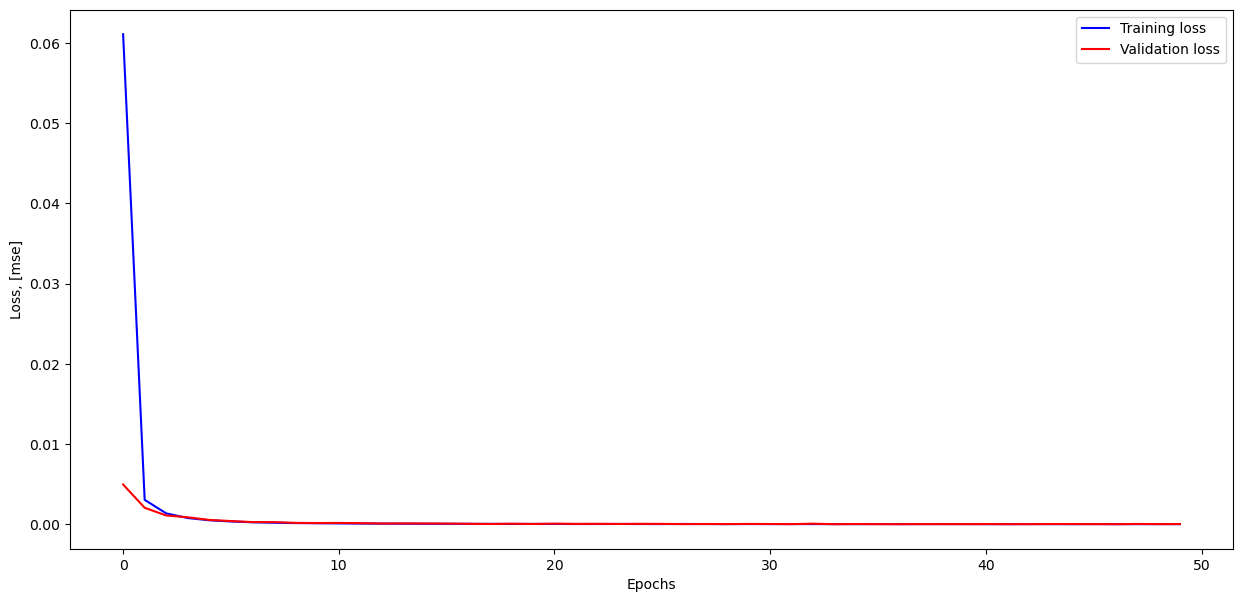

In [9]:
plt.subplots(figsize=(15,7))

plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')

plt.show()

4983/4983 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


/tmp/ipykernel_255296/2060996721.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'],


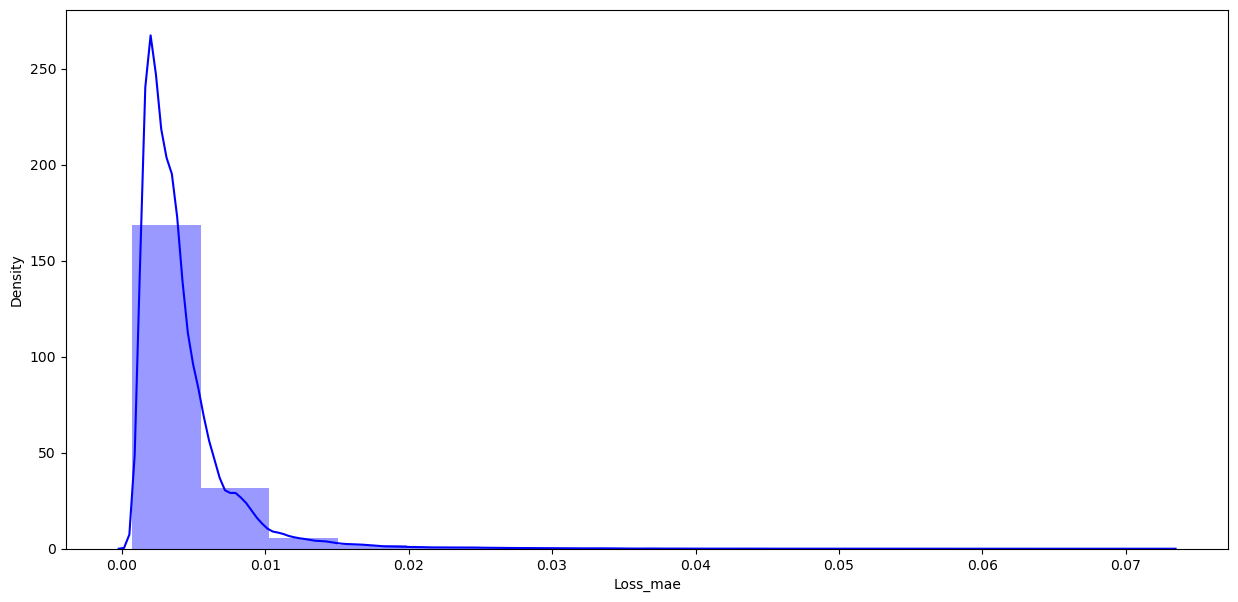

In [10]:
#Reconstructing train data
X_pred = model.predict(np.array(X_train))

#Creating dataframe for reconstructed data
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X_train).index

#Dataframe to get the difference of predicted data and real data. 
scored = pd.DataFrame(index=pd.DataFrame(X_train).index)
#Returning the mean of the loss for each column
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

#plot
plt.subplots(figsize=(15,7))
sns.distplot(scored['Loss_mae'],
             bins = 15, 
             kde= True,
            color = 'blue');

33216/33216 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


Text(0, 0.5, 'Loss, [mse]')

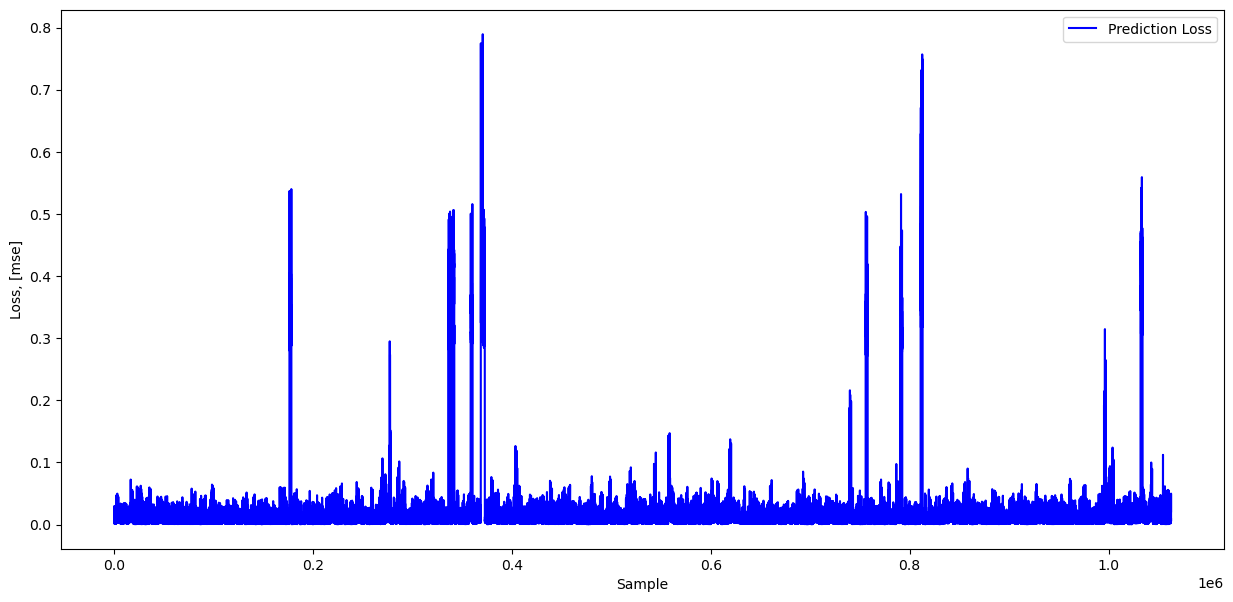

In [11]:
#Reconstructing full data
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X).index

#Returning mean of the losses for each column and putting it in a dataframe
scored = pd.DataFrame(index=pd.DataFrame(X).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

#Plot size
plt.subplots(figsize=(15,7))


#Saving dataframe
scored.to_csv('AutoEncoder_loss.csv')

#Plot
plt.plot(scored['Loss_mae'],'b',label='Prediction Loss')

plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Loss, [mse]')

## Sensor Detection

In [14]:
main_df = pd.read_csv('../datasets/blade_degradation/oneyearcombined.csv')
main_df = main_df.drop(['timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]

seed(10)

act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=200

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Epoch 1/50


/home/shankerabhigyan/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2056 - val_loss: 0.0070
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9368e-04 - val_loss: 7.3447e-04
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7805e-04 - val_loss: 5.6781e-04
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8730e-04 - val_loss: 3.7540e-04
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8663e-04 - val_loss: 3.8992e-04
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2918e-04 - val_loss: 3.8241e-04
Epoch 9/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9545e-04 - val_loss: 2.4113e-04
Epoch 10/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6218e-04 - val_loss: 1.9922e-04
Epoch 11/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4746e-04 - val_loss: 1.1302e-04

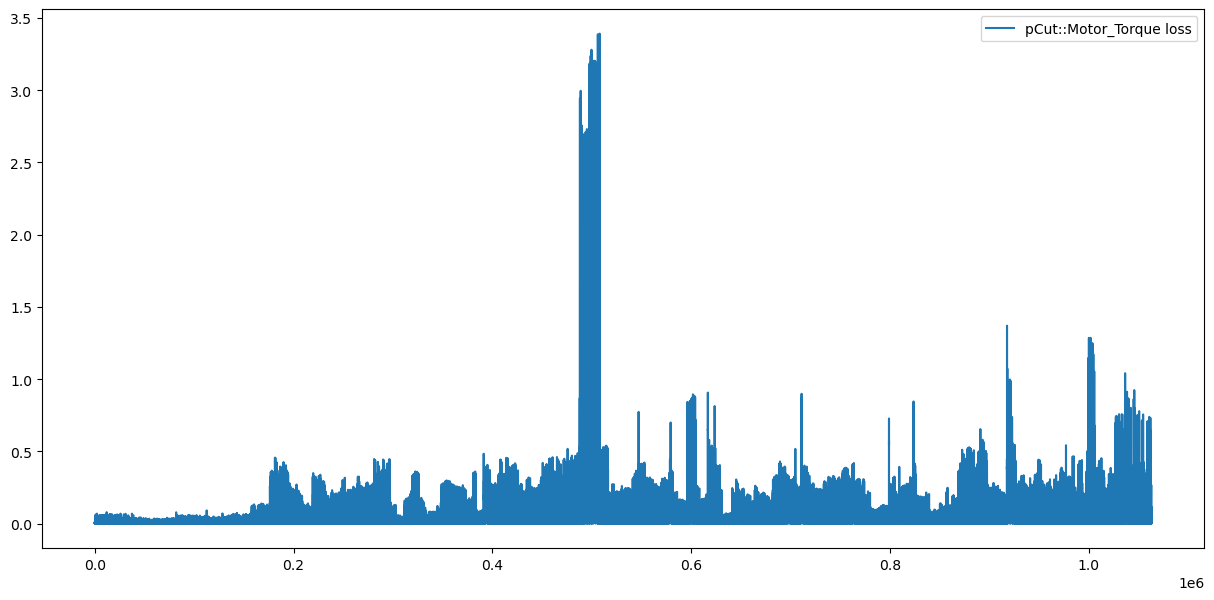

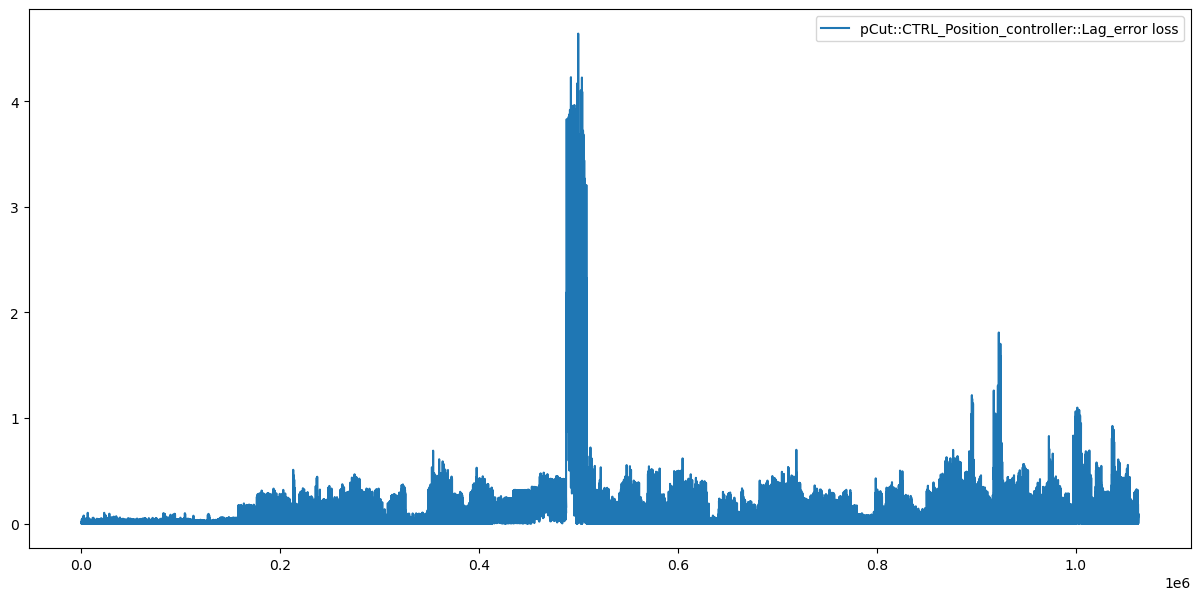

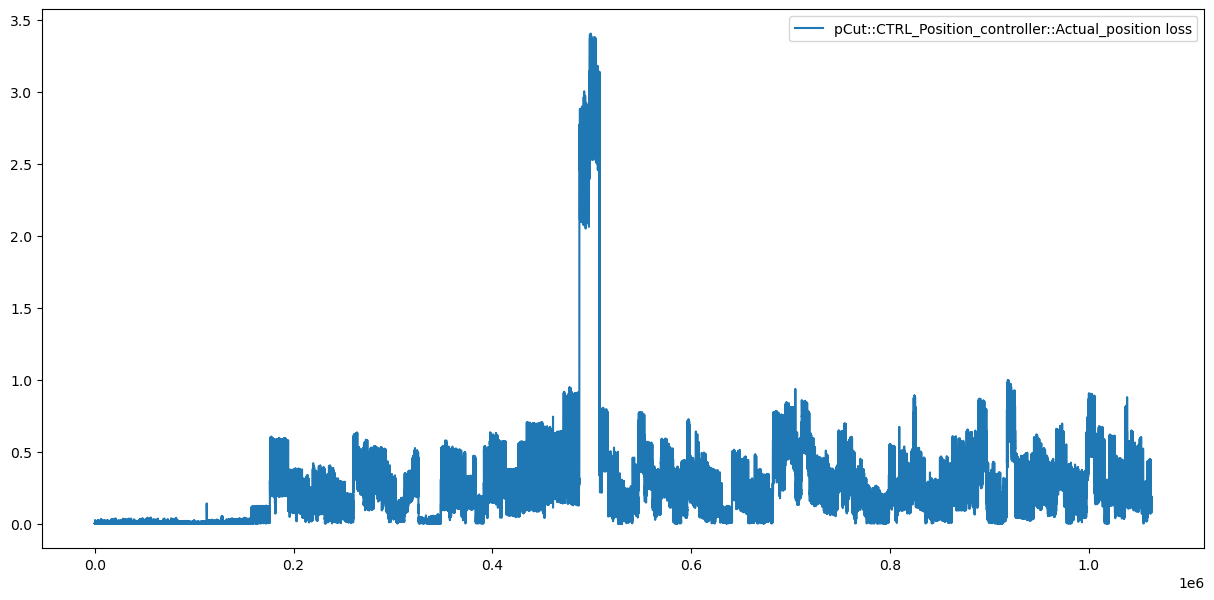

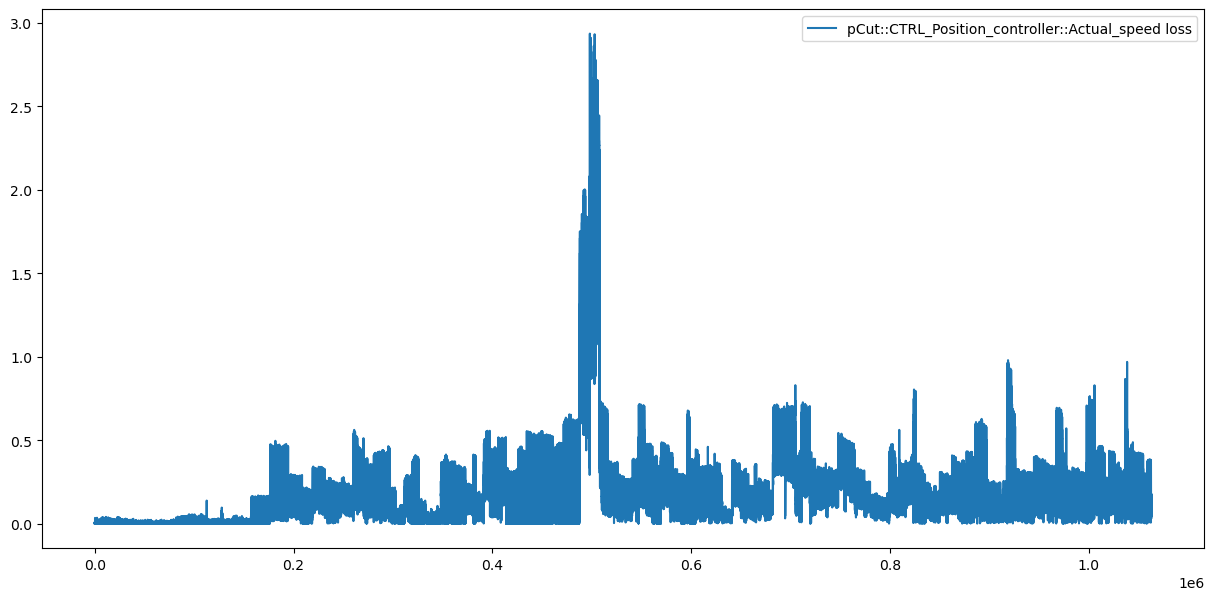

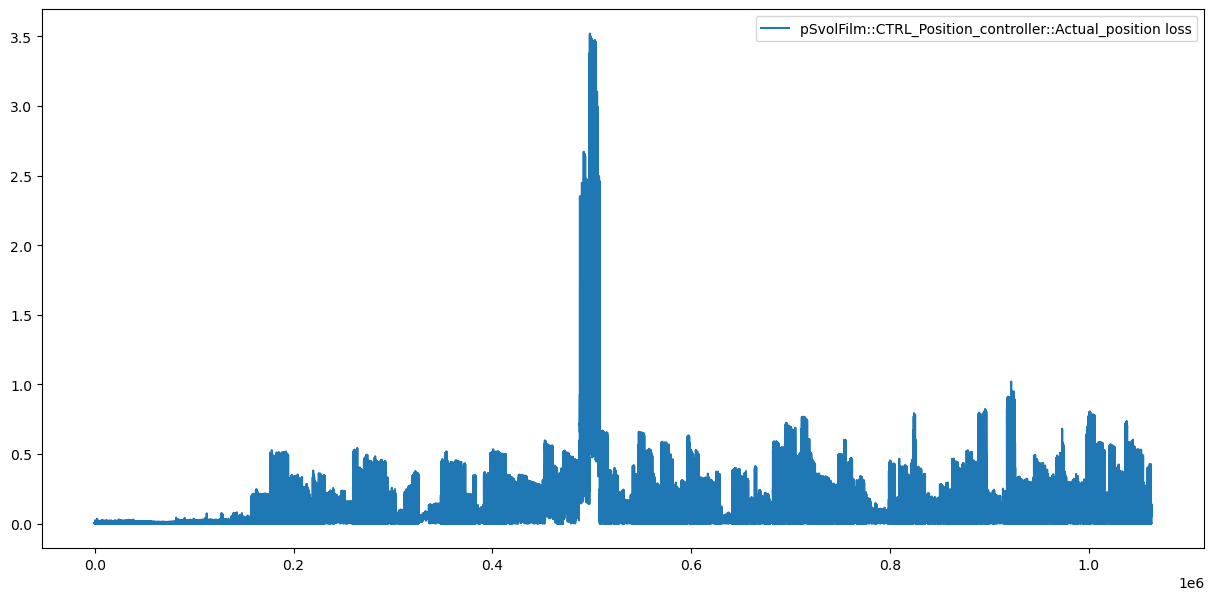

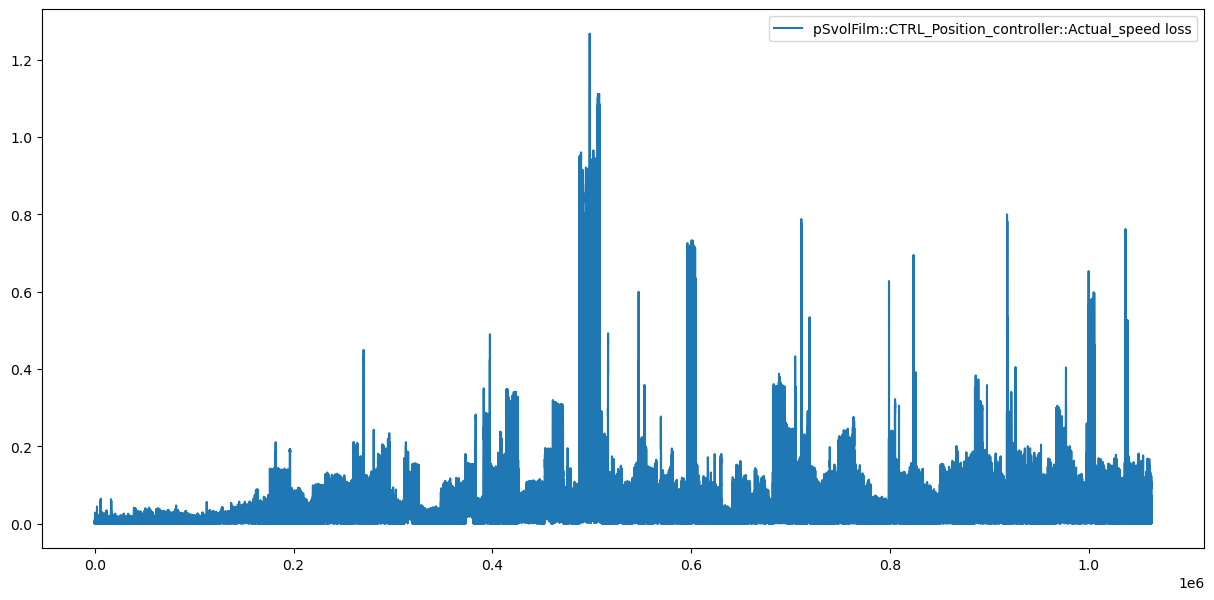

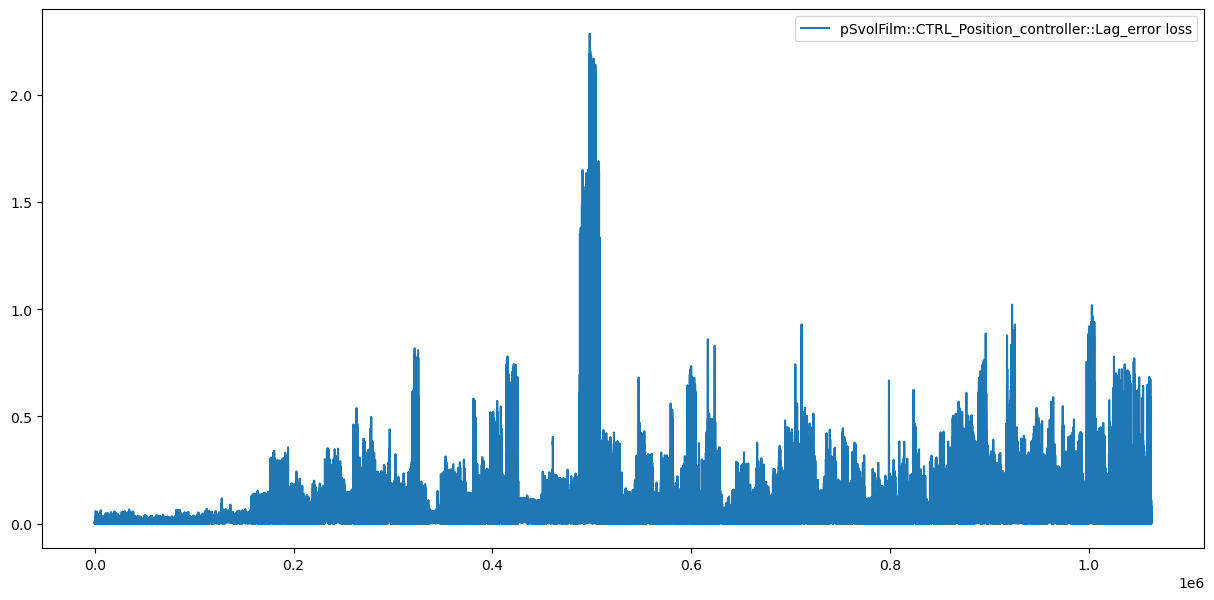

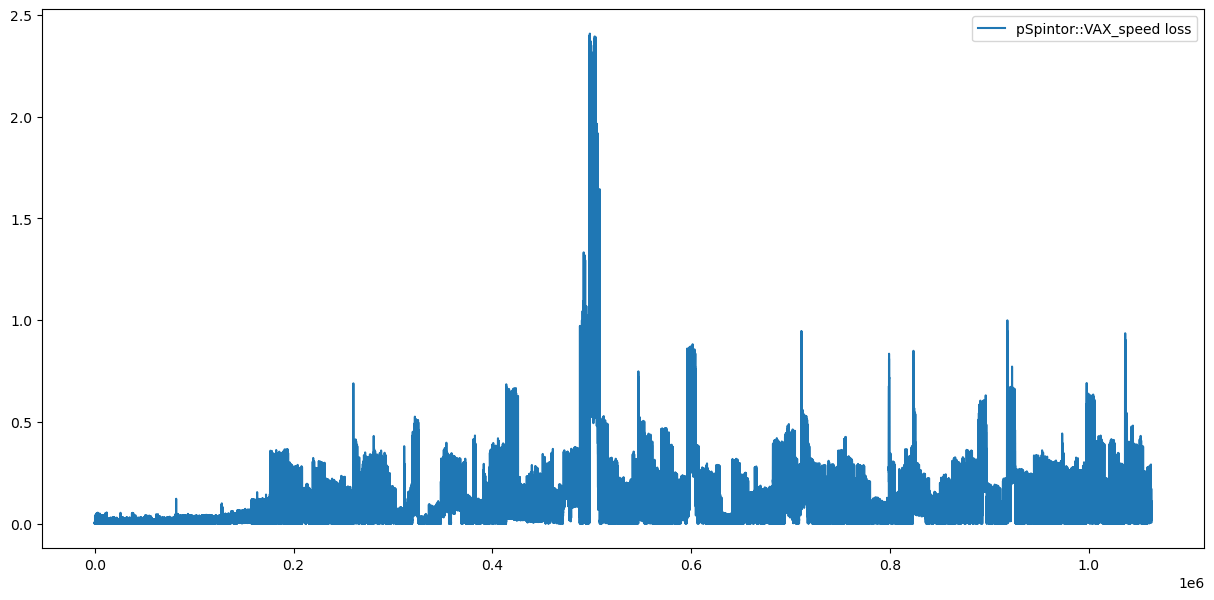

In [17]:
# #Predicting and passing prediction to dataframe
# X_pred = model.predict(np.array(X))
# X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
# X_pred.index = pd.DataFrame(main_df).index

# #Passing X from an array to a dataframe
# X = pd.DataFrame(X,columns=main_df.columns)
# X.index = pd.DataFrame(main_df).index

#Dataframe where all the loss per columns will go
loss_df = pd.read_csv('AutoEncoder_loss_p_column.csv')

#Iterating through columns
for column in main_df.columns:
    #Getting the loss of the prediction for that column
    #loss_df[f'{column}'] = (X_pred[f'{column}'] - X[f'{column}']).abs()
     
    #Plotting the loss
    plt.subplots(figsize=(15,7))
    plt.plot(loss_df.index, loss_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()

#Saving loss Dataframe
#loss_df.to_csv('AutoEncoder_loss_p_column.csv')

In [29]:
from scipy.special import softmax

sftmax_df = pd.read_csv('AutoEncoder_loss_p_column.csv', index_col=0)
sftmax_df = softmax(sftmax_df, axis=1)
sftmax_df = pd.DataFrame(sftmax_df, columns=main_df.columns)

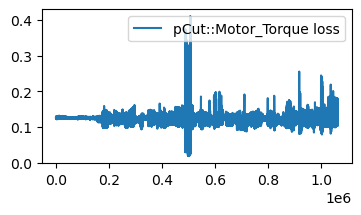

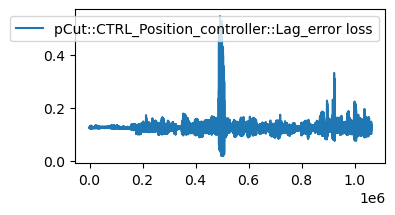

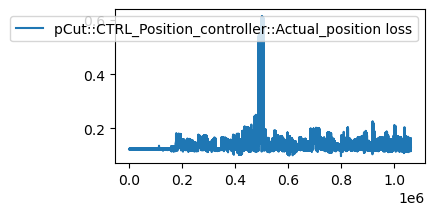

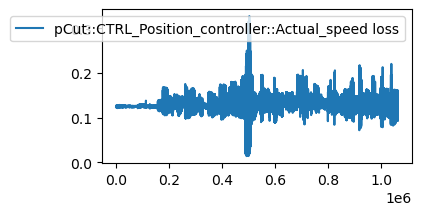

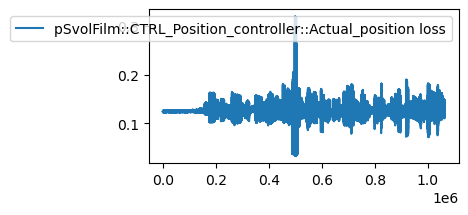

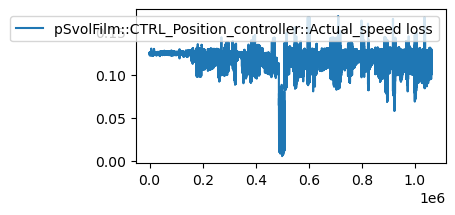

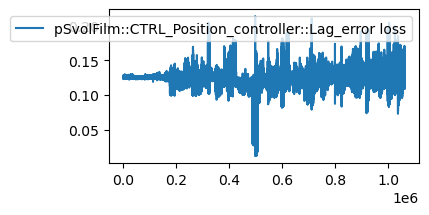

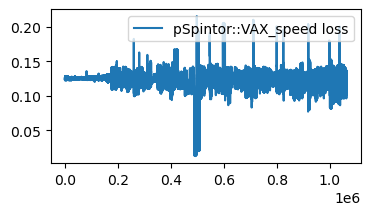

In [33]:
for column in sftmax_df.columns:
    plt.subplots(figsize=(4,2))
    plt.plot(sftmax_df.index, sftmax_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()

(0.0, 1.0)

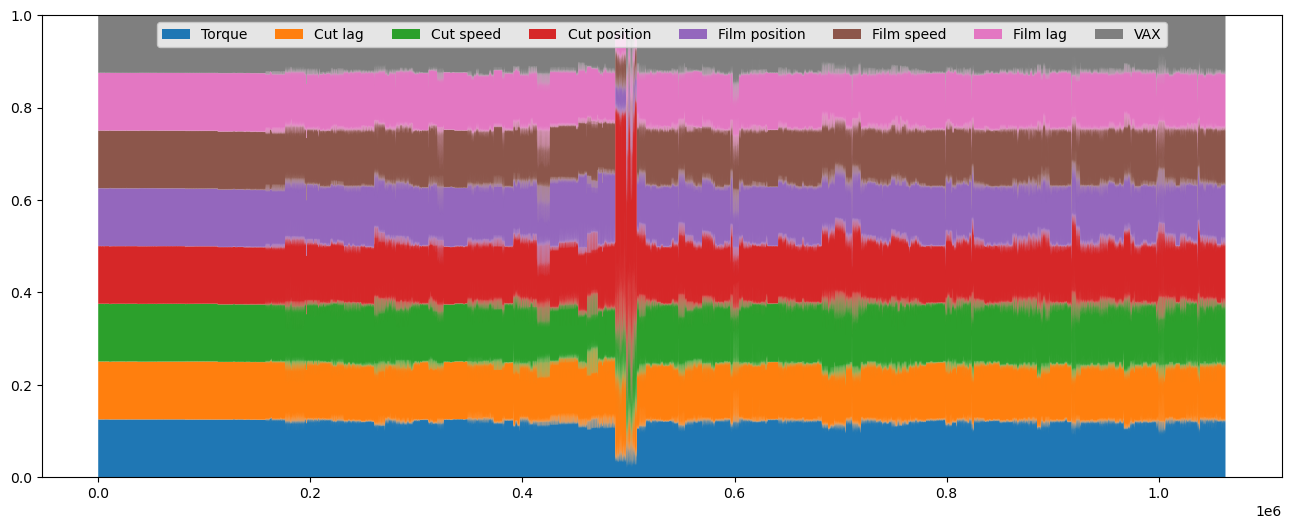

In [36]:
plt.subplots(figsize=(16,6))

#Labels for stackbar plot
df_label = ['Torque', 'Cut lag','Cut speed','Cut position','Film position','Film speed','Film lag','VAX']

#Stackbar plot
plt.stackplot(sftmax_df.index, sftmax_df['pCut::Motor_Torque'],
             sftmax_df['pCut::CTRL_Position_controller::Lag_error'],
             sftmax_df['pCut::CTRL_Position_controller::Actual_speed'],
              sftmax_df['pCut::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Lag_error'],
             sftmax_df['pSpintor::VAX_speed'],
             labels = df_label)

plt.legend(loc='upper center', ncol=8)

plt.ylim(0,1)